# Tukey depth eikonal equation on N-dimensional graphs

In this notebook, we are interested to solve, for any $d\geq 2$,
$$ |\nabla u(x)| - \int_{(y-x) \cdot \nabla u(x) } \rho(y) dS(y) = 0, \quad  x \in \mathbb{R}^d$$
where $\rho$ is the given data density. The viscosity solution of the PDE $u$ will represent the Tukey depth measure of $\rho$. If $\rho$ is a probability measure, then $x$ such that $u(x) = 0.5$ will be the median of $\rho$.

In [1]:
count = 0

In [2]:
import os
if count==0:
    os.chdir('../')
    count = 1
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
building 'MonotoneScheme' extension
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -DVERSION_INFO=0.0.12 -Isrc/ -I/Users/wonjunlee/miniconda3/envs/cv/lib/python3.6/site-packages/pybind11/include -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c src/main.cpp -o build/temp.macosx-10.9-x86_64-3.6/src/main.o -std=c++17 -mmacosx-version-min=10.14 -fvisibility=hidden -g0 -stdlib=libc++ -std=c++14
g++ -bundle -undefined dynamic_lookup -L/Users/wonjunlee/miniconda3/envs/cv

In [3]:
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy import sparse
from MonotoneScheme import EikonalGraph

# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

In [4]:
n = 1000 # number of points
dim = 2 # dimensions


def generate_random_point_cloud_circle(n, dim=2, k=20):
    X = [[0.5 for _ in range(dim)]]
    count = 1
    R = 0.4
    while count < n:
        z = np.random.rand(dim)
        if  np.sum((z-0.5)**2)  <= R**2:
            X.append(z)
            count += 1
    X = np.array(X)

    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W

def process_sparse_data(X, W):
    #Coordinates of sparse matrix for passing to C code
    I,J,V = sparse.find(W)
    K = np.array((J[1:] - J[:-1]).nonzero()) + 1
    K = np.append(0,np.append(K,len(J)))
    X = np.ascontiguousarray(X, np.float64)
    V = np.ascontiguousarray(V, np.float64)
    K = np.ascontiguousarray(K, np.int32)
    I = np.ascontiguousarray(I, np.int32)
    return X,V,I,K
X, W = generate_random_point_cloud_circle(n,dim,30) # first param: number of points # second param: number of neighbord points
X,V,I,K = process_sparse_data(X,W)

mask    = (np.sum((X-0.5)**2,axis=1) > 0.38**2)
bdy_pts = np.arange(n)[mask]

print("Solve Tukey")




Solve Tukey
I (31938,)
J (31938,)
V (31938,)
K (1001,)
bdy: (103,)
[ 13  17  18  23  34  39  45  48  62  63  64  65  69  86 104 142 152 160
 175 190 191 195 199 205 216 224 228 229 230 254 264 272 294 305 312 322
 329 333 335 341 359 366 376 380 383 386 398 404 412 419 434 443 447 451
 452 460 478 484 493 497 504 513 523 538 546 551 562 573 575 581 590 593
 620 628 642 663 664 717 727 733 760 778 789 800 817 834 836 837 864 870
 871 873 883 903 913 932 935 936 954 956 958 970 982]


In [8]:
f = np.ones((n))
u = np.zeros((n))
max_it = 1000
tol    = -1e-10
solver = EikonalGraph(X, V, I, K, f, bdy_pts)

interior: 897 threads:  1


In [9]:
for i in tqdm.tqdm(range(max_it)):
    error = solver.iterate(u)
    if error < tol:
        break

100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


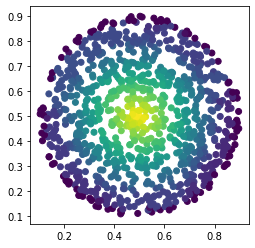

In [10]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(X[:,0], X[:,1], c=u)
# ax[i].axis('off')
ax.set_aspect('equal')
plt.show()